# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

# python bultin lib
import json
from collections import OrderedDict
from PIL import Image

# numpy
import numpy as np

# pytorch
import torch
import torch.nn.functional as F
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

# matplotlib
import matplotlib.pyplot as plt

# misc
from tqdm import tqdm


C:\Users\Beng_Hwee_Toh\Anaconda3\envs\udacity\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
## define some variabe which is commonly used
## can be used throughout this notebook
means = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]
image_size = 224
batch_size = 32
# Hidden layer for classifier
hidden_units = 4096
learning_rate = 0.001
# choose a architecture
arch = "vgg16" #"vgg16" #"densenet161"
device_mode = "gpu"
# set the epoch to run
epochs = 5
checkpoint_filename = 'checkpoint.pth'
# Only remove if you do not need the model anymore
# default set to False to prevent accidentally delete
delete_checkpoint = False


In [4]:
# Define your execution device
if device_mode == "gpu":
    #if gpu not avaliable else fall back to cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
    
print("The model will be running on", device, "device")

The model will be running on cpu device


In [5]:

# Define your transforms for the training, validation, and testing sets
data_transforms = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(p=0.30),
                                     transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means, std_dev)]),
        "validate": transforms.Compose([transforms.Resize(image_size + 1),
                                          transforms.CenterCrop(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(means, std_dev)]),
        "test": transforms.Compose([transforms.Resize(image_size + 1),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means, std_dev)])
}

# Load the datasets with ImageFolder
image_datasets = {
        "train": datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
        "validate": datasets.ImageFolder(valid_dir, transform=data_transforms["validate"]),
        "test": datasets.ImageFolder(test_dir, transform=data_transforms["test"])
}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
        "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True),
        "validate": torch.utils.data.DataLoader(image_datasets["validate"], batch_size=batch_size),
        "test": torch.utils.data.DataLoader(image_datasets["test"], batch_size=batch_size)
}

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'flowers/train'

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print('Total Label Count : ' , len(cat_to_name))

Total Label Count :  102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [7]:
# Build and train your network

# output size according to the category to classify
output_size = len(cat_to_name)

# VGG16 or densenet161,  rem to set the arch variable
if arch == "densenet161":
    model = models.densenet161(pretrained=True)
    # Get the current input size from densenet161 classifier
    input_size = model.classifier.in_features
else:
    model = models.vgg16(pretrained=True)
    # Get the current input size from vgg16 classifier
    input_size = model.classifier[0].in_features
    
# Prevent backpropagation on parameters
for param in model.parameters():
    param.requires_grad = False 
    


# Define own classifier
new_classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(in_features= input_size, out_features= hidden_units , bias=True)),
        ('relu1', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(in_features= hidden_units, out_features= hidden_units , bias=True)),
        ('relu2', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.5)),
        ('output2', nn.Linear(in_features= hidden_units, out_features= output_size, bias=True)),
        # LogSoftmax is needed by NLLLoss criterion
        ('softmax', nn.LogSoftmax(dim=1))
    ]))

# Set the original classifier with our own
model.classifier = new_classifier

# Print to inspect  classifier of the model
print(model.classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 109136309.87it/s]


Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (relu2): ReLU()
  (output2): Linear(in_features=4096, out_features=102, bias=True)
  (softmax): LogSoftmax()
)


In [8]:

# The negative log likelihood loss as criterion.
loss_fn = nn.NLLLoss()

# Adam: Stochastic Optimization
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [9]:
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [10]:
# Function to test the model with the validation dataset and compute the accuracy for the validation images
def check_accuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in dataloaders['validate']:
            images, labels = data
            # add this line else it will throw error when using gpu
            # any better way to switch between cpu and gpu ?
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [11]:
# Define the method train
def train(epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for (images, labels) in tqdm(dataloaders['train']):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()
            running_loss += loss.item()     # extract the loss value
            # zero the loss
            
        # Compute and print the average accuracy fo this epoch when validation test images
        accuracy = check_accuracy()
        print('epoch', epoch+1,' accuracy over the whole test set is %d %%' % (accuracy))
        print('[epoch %d] loss: %.3f' % (epoch + 1 , running_loss / len(dataloaders['train'])))
        

In [12]:
# start training here
# introduce the tqdm lib to view the training progress
train(epochs)

  0%|          | 0/205 [00:00<?, ?it/s]

epoch 1  accuracy over the whole test set is 55 %
[epoch 1] loss: 3.258


  0%|          | 0/205 [00:00<?, ?it/s]

epoch 2  accuracy over the whole test set is 73 %
[epoch 2] loss: 1.487


  0%|          | 0/205 [00:00<?, ?it/s]

epoch 3  accuracy over the whole test set is 78 %
[epoch 3] loss: 1.174


  0%|          | 0/205 [00:00<?, ?it/s]

epoch 4  accuracy over the whole test set is 78 %
[epoch 4] loss: 0.974


100%|██████████| 205/205 [03:09<00:00,  1.11it/s]


epoch 5  accuracy over the whole test set is 82 %
[epoch 5] loss: 0.890


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Do validation on the test set
def validation():
    correct = 0
    total = 0
    total_images = len(dataloaders["test"].batch_sampler) * dataloaders["test"].batch_size

    # Disabling gradient calculation
    with torch.no_grad():
        for (images, labels) in tqdm(dataloaders["test"]):
            # Move images and labeles perferred device
            # if they are not already there
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accurately classified {(100 * correct // total):d}% of {total_images} images.')
    
# Perform validation
validation()

100%|██████████| 26/26 [00:21<00:00,  1.29it/s]

Accurately classified 78% of 832 images.


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# Save the checkpoint
def save_checkpoint(model_state, file='checkpoint.pth'):
    torch.save(model_state, file)


model.class_to_idx = image_datasets['train'].class_to_idx
model_state = {
    'epoch': epochs,
    'arch': arch,
    'state_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'classifier': new_classifier,
    'class_to_idx': model.class_to_idx,
}

# Save a copy now
save_checkpoint(model_state, checkpoint_filename)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(file='checkpoint.pth'):
    model_state = torch.load(file, map_location=lambda storage, loc: storage)
    
    if model_state['arch'] == "vgg16":
        model = models.vgg16(pretrained=True)
    else:
        model = models.densenet161(pretrained=True)
    model.classifier = model_state['classifier']
    model.load_state_dict(model_state['state_dict'])
    model.class_to_idx = model_state['class_to_idx']

    return model


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''       
    pil_image = Image.open(image).convert("RGB")
    
    # Any reason not to let transforms do all the work here?
    in_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(means, std_dev)])
    pil_image = in_transforms(pil_image)

    return pil_image


# Process a PIL image for use in a PyTorch model
sample_image = process_image(valid_dir + '/1/image_06739.jpg')    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

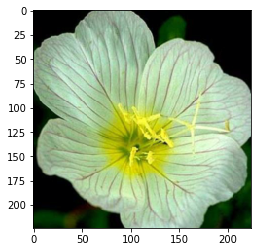

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


# try show the image
imshow(sample_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Implement the code to predict the class from an image file
    
    model.eval()
    
    # load image as torch.Tensor
    image = process_image(image_path)
    
    # Unsqueeze returns a new tensor with a dimension of size one
    image = image.unsqueeze(0)
    
    # Disabling gradient calculation 
    with torch.no_grad():
        output = model.forward(image)
        top_prob, top_labels = torch.topk(output, topk)
        top_prob = top_prob.exp()
        
    class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    
    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])
        
    return top_prob.numpy()[0], mapped_classes
    
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

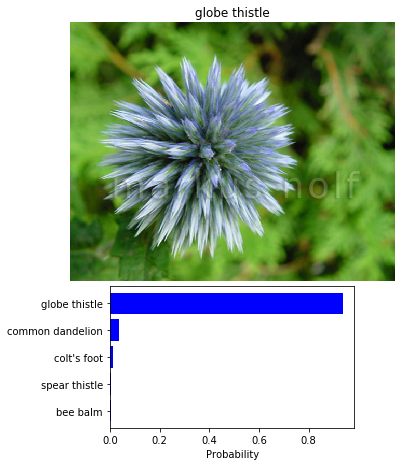

Correct classification: globe thistle
Correct prediction: True


In [19]:
# Display an image along with the top 5 classes

image_file = valid_dir + '/10/image_07102.jpg'
#cat_to_name
correct_class = cat_to_name['10']
chkp_model = load_checkpoint(checkpoint_filename)
top_prob, top_classes = predict(image_file, chkp_model)


label = top_classes[0]

fig = plt.figure(figsize=(8,8))
img_plt = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
chart_plt = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_file)
img_plt.axis('off')
img_plt.set_title(f'{cat_to_name[label]}')
img_plt.imshow(image)

labels = []
for class_idx in top_classes:
    labels.append(cat_to_name[class_idx])

yp = np.arange(5)
chart_plt.set_yticks(yp)
chart_plt.set_yticklabels(labels)
chart_plt.set_xlabel('Probability')
chart_plt.invert_yaxis()
chart_plt.barh(yp, top_prob, xerr=0, align='center', color='blue')

plt.show()
print(f'Correct classification: {correct_class}')
print(f'Correct prediction: {correct_class == cat_to_name[label]}')

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [21]:
# remove .pth files or move it to a temporary `~/opt` directory in this Workspace
if delete_checkpoint:
    os.remove(checkpoint_filename)
    files = [f for f in os.listdir('.') if os.path.isfile(f)]
    print(files)